# Segmenting and Clustering Neighborhoods in Toronto

## Part 1: Postal Codes

#### Scrape the Wikipedia page in order to obtain the data that is in the table of postal codes.

In [1]:
import requests
from bs4 import BeautifulSoup

# read html
url = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
htmltext = url.text

# extract table from html
soup = BeautifulSoup(htmltext)
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')

data = []
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]
    data.append(cols)
data

[[],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront'],
 ['M6A', 'North York', 'Lawrence Manor, Lawrence Heights'],
 ['M7A', 'Downtown Toronto', "Queen's Park, Ontario Provincial Government"],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue, Humber Valley Village'],
 ['M1B', 'Scarborough', 'Malvern, Rouge'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills'],
 ['M4B', 'East York', 'Parkview Hill, Woodbine Gardens'],
 ['M5B', 'Downtown Toronto', 'Garden District, Ryerson'],
 ['M6B', 'North York', 'Glencairn'],
 ['M7B', 'Not assigned', 'Not assigned'],
 ['M8B', 'Not assigned', 'Not assigned'],
 ['M9B',
  'Etobicoke',
  'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale'],
 ['M1C', 'Scarborough', 'Rouge Hill, Port Union, Highland Creek'],

#### Transform the data into a pandas dataframe

In [6]:
import pandas as pd
postal_codes = pd.DataFrame(data[1:], columns=['PostalCode', 'Borough', 'Neighborhood'])
print('Total records: {0}'.format(len(postal_codes)))
postal_codes.head()

Total records: 180


PostalCode           Borough               Neighborhood
0        M1A      Not assigned               Not assigned
1        M2A      Not assigned               Not assigned
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront

#### Clean up data

In [7]:
# drop rows with a borough that is Not assigned
postal_codes = postal_codes[postal_codes.Borough != "Not assigned"].reset_index(drop=True)
print(postal_codes.head())
postal_codes.shape

  PostalCode           Borough                                 Neighborhood
0        M3A        North York                                    Parkwoods
1        M4A        North York                             Victoria Village
2        M5A  Downtown Toronto                    Regent Park, Harbourfront
3        M6A        North York             Lawrence Manor, Lawrence Heights
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government


(103, 3)

In [8]:
# combined rows with the same postal code 
#postal_codes = postal_codes.groupby('PostalCode').agg({'Borough': 'first',
#                                                      'Neighborhood': ', '.join}).reset_index()

# WE DO NOT HAVE SUCH ROWS: all post codes had only one row
print('Each post code has only one instance:', postal_codes.PostalCode.count() == len(postal_codes.PostalCode.unique()))
postal_codes.shape

Each post code has only one instance: True


(103, 3)

In [9]:
# if row has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
#postal_codes.Neighborhood[postal_codes.Neighborhood == "Not assigned"] = postal_codes.Borough

# WE DO NOT HAVE SUCH ROWS: all neighborhoods are assigned
print('All neighborhoods are assigned: ', len(postal_codes[postal_codes.Neighborhood == "Not assigned"])==0)
postal_codes.shape

All neighborhoods are assigned:  True


(103, 3)

#### Final number of rows of Postal Codes

In [10]:
postal_codes.shape

(103, 3)

## Part 2: Coordinates

####  Get the latitude and longitude coordinates for postal codes

In [12]:
# read coordinates related to postal codes
coordinates = pd.read_csv('Geospatial_Coordinates.csv')
coordinates.columns = ['PostalCode', 'Latitude', 'Longitude']
coordinates.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [13]:
# merge postal codes with coordinates
postal_codes = postal_codes.merge(coordinates, on='PostalCode', how='left')
postal_codes.head()

PostalCode           Borough                                 Neighborhood  \
0        M3A        North York                                    Parkwoods   
1        M4A        North York                             Victoria Village   
2        M5A  Downtown Toronto                    Regent Park, Harbourfront   
3        M6A        North York             Lawrence Manor, Lawrence Heights   
4        M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [14]:
print("All postal codes have coordinates: ", not(postal_codes.Latitude.isnull().any() or postal_codes.Latitude.isnull().any()))
postal_codes.shape

All postal codes have coordinates:  True


(103, 5)

## Part 3: Explore and cluster the neighborhoods in Toronto

#### Import all necessary libraries

In [15]:
import numpy as np # library to handle data in a vectorized manner

#import pandas as pd # library for data analsysis, already imported
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#import requests # library to handle requests, already imported
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Select only boroughs that contain the word Toronto 

In [16]:
toronto = postal_codes[postal_codes.Borough.str.contains('Toronto')]
toronto.shape

(39, 5)

In [17]:
print('Toronto has {} boroughs and {} neighborhoods.'.format(
        len(toronto['Borough'].unique()),
        toronto.shape[0]
    )
)

Toronto has 4 boroughs and 39 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto

In [18]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [19]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#006666',
        weight=1,
        fill=True,
        fill_color='#CDFFFF',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Screenshot
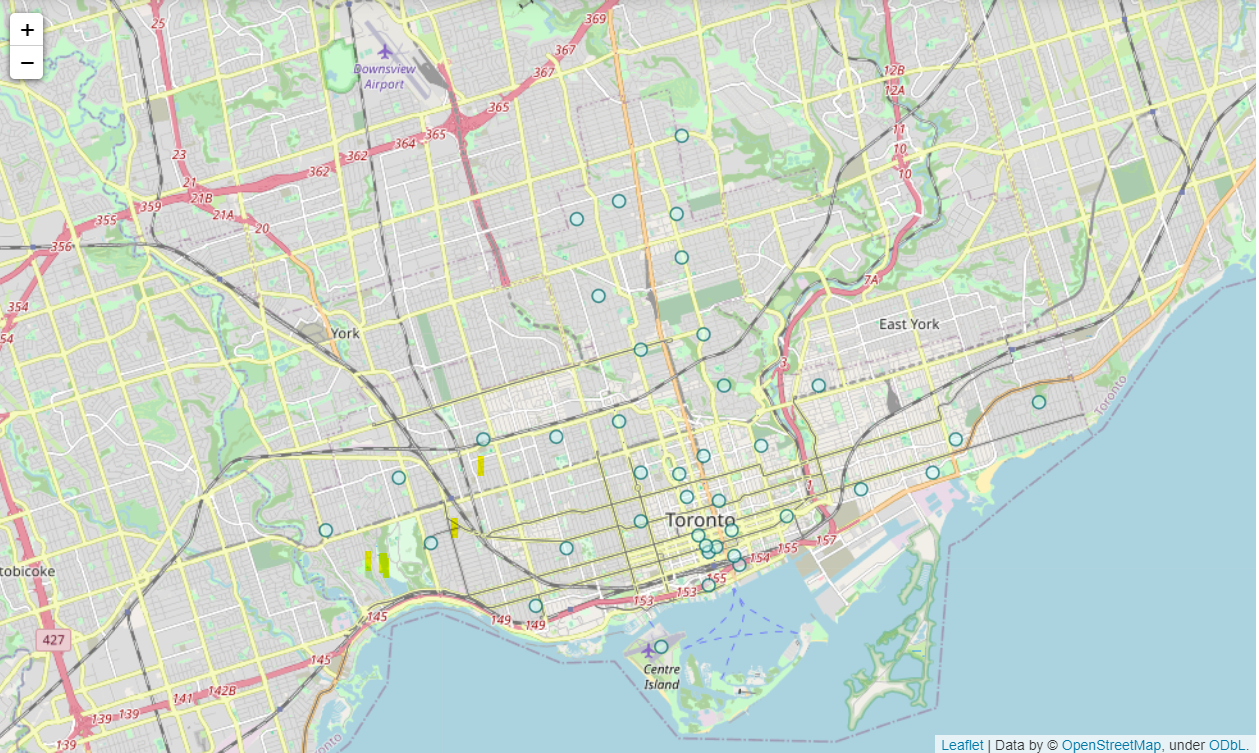

#### Define Foursquare Credentials and Version

In [20]:
CLIENT_ID = 'Y0FH2414BMQTZ3YE3LM0HXEDJCFJ3OQDLUOAN4U4YGZ3GUHS' # your Foursquare ID
CLIENT_SECRET = 'SCC5MVIPC0UTLIPRF5YQQGCE1CU4RGRNTTM22OG5WSVKJ3NM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y0FH2414BMQTZ3YE3LM0HXEDJCFJ3OQDLUOAN4U4YGZ3GUHS
CLIENT_SECRET:SCC5MVIPC0UTLIPRF5YQQGCE1CU4RGRNTTM22OG5WSVKJ3NM


#### Get the top 100 venues around each neighborhood within a radius of 500 meters

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

(1605, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65426              -79.360636   
1  Regent Park, Harbourfront               43.65426              -79.360636   
2  Regent Park, Harbourfront               43.65426              -79.360636   
3  Regent Park, Harbourfront               43.65426              -79.360636   
4  Regent Park, Harbourfront               43.65426              -79.360636   

                    Venue  Venue Latitude  Venue Longitude  \
0           Tandem Coffee       43.653559       -79.361809   
1        Roselle Desserts       43.653447       -79.362017   
2  Cooper Koo Family YMCA       43.653249       -79.358008   
3     Body Blitz Spa East       43.654735       -79.359874   
4          Impact Kitchen       43.656369       -79.356980   

        Venue Category  
0          Coffee Shop  
1               Bakery  
2  Distribution Center  
3                  Spa  
4           Restaurant

#### Check how many venues were returned for each neighborhood

In [23]:
toronto_venues.groupby('Neighborhood').Venue.count()

Neighborhood
Berczy Park                                                                                                    55
Brockton, Parkdale Village, Exhibition Place                                                                   22
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto                           17
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     18
Central Bay Street                                                                                             60
Christie                                                                                                       16
Church and Wellesley                                                                                           78
Commerce Court, Victoria Hotel                                                                                100
Davisville                                                                 

#### Check how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


#### Analyze each Neighborhood

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
columns = toronto_onehot.columns
print("Number of columns before moving 'Neighborhood':", len(columns))

# move neighborhood column to the first column
idx = columns.get_loc("Neighborhood")
columns = list(columns) # convert to list
print("Idx of column 'Neighborhood'", idx)
print("Move 'Neighborhood' to the first column")
fixed_columns = [columns[idx]] + columns[:idx] + columns[idx+1:]
toronto_onehot = toronto_onehot[fixed_columns]
print("Number of columns after moving 'Neighborhood':", len(toronto_onehot.columns))

toronto_onehot.head()

Number of columns before moving 'Neighborhood': 236
Idx of column 'Neighborhood' 164
Move 'Neighborhood' to the first column
Number of columns after moving 'Neighborhood': 236


Neighborhood  Airport  Airport Food Court  Airport Gate  \
0  Regent Park, Harbourfront        0                   0             0   
1  Regent Park, Harbourfront        0                   0             0   
2  Regent Park, Harbourfront        0                   0             0   
3  Regent Park, Harbourfront        0                   0             0   
4  Regent Park, Harbourfront        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0             0         0            0           0                    0   
1             0         0            0           0                    0   
2             0         0            0           0                    0   
3             0         0            0           0                    0   
4             0         0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Workshop  BBQ Joint  Baby Store  \
0                 0                   0              0          0           0   
1                 0                   0              0          0           0   
2                 0                   0              0          0           0   
3                 0                   0              0          0           0   
4                 0                   0              0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Stadium  Basketball Stadium  Beach  \
0           0       0     0    0                 0                   0      0   
1           0       1     0    0                 0                   0      0   
2           0       0     0    0                 0                   0      0   
3           0       0     0    0                 0                   0      0   
4           0       0     0    0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0                0         0           0                   0       0   
1                0         0           0                   0       0   
2                0         0           0                   0       0   
3                0         0           0                   0       0   
4                0         0           0                   0       0   

   Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  \
0              0          0         0                     0               0   
1              0          0         0                     0               0   
2              0          0         0                     0               0   
3              0          0         0                     0               0   
4              0          0         0                     0               0   

   Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0        0                0         0             0              0         0   
1        0                0         0             0              0         0   
2        0                0         0             0              0         0   
3        0                0         0             0              0         0   
4        0                0         0             0              0         0   

   Butcher  Café  Cajun / Creole Restaurant  Candy Store  \
0        0     0                          0            0   
1        0     0                          0            0   
2        0     0                          0            0   
3        0     0                          0     

In [26]:
toronto_onehot.shape

(1605, 236)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood   Airport  \
0                                         Berczy Park  0.000000   
1        Brockton, Parkdale Village, Exhibition Place  0.000000   
2   Business reply mail Processing Centre, South C...  0.000000   
3   CN Tower, King and Spadina, Railway Lands, Har...  0.055556   
4                                  Central Bay Street  0.000000   
5                                            Christie  0.000000   
6                                Church and Wellesley  0.000000   
7                      Commerce Court, Victoria Hotel  0.000000   
8                                          Davisville  0.000000   
9                                    Davisville North  0.000000   
10                       Dufferin, Dovercourt Village  0.000000   
11             First Canadian Place, Underground city  0.000000   
12    Forest Hill North & West, Forest Hill Road Park  0.000000   
13                           Garden District, Ryerson  0.000000   
14  Harbourfront East, Union Station, Toronto Islands  0.000000   
15                      High Park, The Junction South  0.000000   
16                     India Bazaar, The Beaches West  0.000000   
17          Kensington Market, Chinatown, Grange Park  0.000000   
18                                      Lawrence Park  0.000000   
19                           Little Portugal, Trinity  0.000000   
20                        Moore Park, Summerhill East  0.000000   
21                 North Toronto West,  Lawrence Park  0.000000   
22                             Parkdale, Roncesvalles  0.000000   
23        Queen's Park, Ontario Provincial Government  0.000000   
24                          Regent Park, Harbourfront  0.000000   
25                           Richmond, Adelaide, King  0.000000   
26                                           Rosedale  0.000000   
27                                           Roselawn  0.000000   
28                                 Runnymede, Swansea  0.000000   
29                                     St. James Town  0.000000   
30                        St. James Town, Cabbagetown  0.000000   
31                                     Stn A PO Boxes  0.000000   
32                                    Studio District  0.000000   
33  Summerhill West, Rathnelly, South Hill, Forest...  0.000000   
34                The Annex, North Midtown, Yorkville  0.000000   
35                                        The Beaches  0.000000   
36                       The Danforth West, Riverdale  0.000000   
37           Toronto Dominion Centre, Design Exchange  0.000000   
38                     University of Toronto, Harbord  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.000000      0.000000        0.000000         0.000000   
1             0.000000      0.000000        0.000000         0.000000   
2             0.000000      0.000000        0.000000         0.000000   
3             0.055556      0.055556        0.111111         0.166667   
4             0.000000      0.000000        0.000000         0.000000   
5             0.000000      0.000000        0.000000         0.000000   
6             0.000000      0.000000        0.000000         0.000000   
7             0.000000      0.000000        0.000000         0.000000   
8             0.000000      0.000000        0.000000         0.000000   
9             0.000000      0.000000        0.000000         0.000000   
10            0.000000      0.000000        0.000000         0.000000   
11            0.000000      0.000000        0.000000         0.000000   
12            0.000000      0.000000        0.000000         0.000000   
13            0.000000      0.000000        0.000000         0.000000   
14            0.000000      0.000000        0.000000         0.000000   
15            0.000000      0.000000        0.000000         0.000000   
16            0.000000      0.000000        0.000000         0.000000   
17            0.000000      0.000000        0.

In [28]:
toronto_grouped.shape

(39, 236)

#### Print each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2      Farmers Market  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3    Intersection  0.05
4         Stadium  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
           venue  freq
0    Yoga Studio  0.06
1  Garden Center  0.06
2           Park  0.06
3     Comic Shop  0.06
4     Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1                Café 

#### Create dataframewith 10 top venues for each neighborhood

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Berczy Park           Coffee Shop   
1       Brockton, Parkdale Village, Exhibition Place                  Café   
2  Business reply mail Processing Centre, South C...           Yoga Studio   
3  CN Tower, King and Spadina, Railway Lands, Har...       Airport Service   
4                                 Central Bay Street           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0          Cocktail Bar              Beer Bar                 Bakery   
1           Coffee Shop        Breakfast Spot  Performing Arts Venue   
2         Auto Workshop                  Park            Pizza Place   
3        Airport Lounge      Airport Terminal        Harbor / Marina   
4                  Café    Italian Restaurant         Sandwich Place   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0    Seafood Restaurant        Farmers Market           Cheese Shop   
1                Bakery             Nightclub             Pet Store   
2            Restaurant               Butcher         Burrito Place   
3      Sculpture Garden    Airport Food Court          Airport Gate   
4           Salad Place       Bubble Tea Shop          Burger Joint   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0             Restaurant   Japanese Restaurant                  Hotel  
1           Climbing Gym            Restaurant          Burrito Place  
2                Brewery    Light Rail Station             Skate Park  
3                    Bar         Boat or Ferry               Boutique  
4  Portuguese Restaurant     Indian Restaurant    Japanese Restaurant

In [54]:
# should be (39,11)
neighborhoods_venues_sorted.shape

(39, 11)

### Cluster Neighborhoods
#### Run k-means to cluster the neighborhood into 4 clusters

In [55]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [56]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto.copy()

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

PostalCode           Borough                                 Neighborhood  \
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
9         M5B  Downtown Toronto                     Garden District, Ryerson   
15        M5C  Downtown Toronto                               St. James Town   
19        M4E      East Toronto                                  The Beaches   

     Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
2   43.654260 -79.360636               0           Coffee Shop   
4   43.662301 -79.389494               0           Coffee Shop   
9   43.657162 -79.378937               0        Clothing Store   
15  43.651494 -79.375418               0           Coffee Shop   
19  43.676357 -79.293031               0                   Pub   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2                   Park                Bakery                   Pub   
4       Sushi Restaurant           Yoga Studio              Creperie   
9            Coffee Shop   Japanese Restaurant                  Café   
15                  Café   American Restaurant                 Hotel   
19     Health Food Store      Asian Restaurant                 Trail   

   5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
2         Breakfast Spot                  Café                    Theater   
4         Sandwich Place         Burrito Place                       Café   
9                  Hotel        Cosmetics Shop  Middle Eastern Restaurant   
15          Cocktail Bar             Gastropub                   Creperie   
19           Yoga Studio   Dumpling Restaurant        Distribution Center   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
2             Yoga Studio            Shoe Store                Brewery  
4   Portuguese Restaurant    College Auditorium                   Park  
9         Bubble Tea Shop    Italian Restaurant            Pizza Place  
15         Clothing Store              Beer Bar             Restaurant  
19                Dog Run      Doner Restaurant             Donut Shop

#### Visualize the resulting clusters

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Screenshot
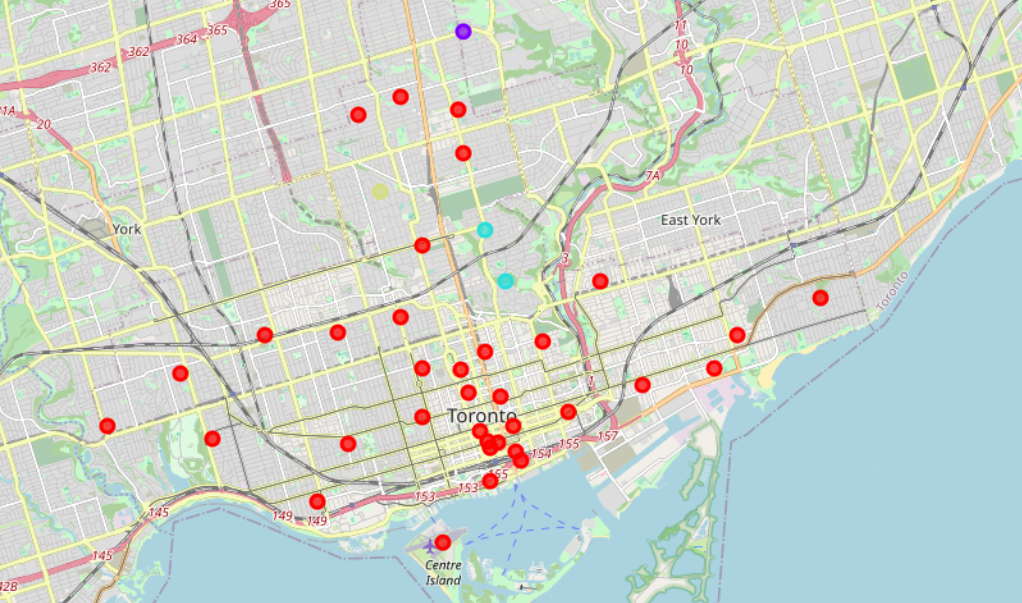

### Examine clusters

As we can see all neighborhoods in Totronto are pretty similar. This is тче city with a developed infrastructure. All neighborhoods have a variety of restaurants, shops and cultural venues. This way we can see that the most of neighbirhoods are combined in one cluster - Cluster1.  

#### Clauster 1:  neighborhoods of these cluster are united the variety of restaurants, shops and cultural venues.

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
2    Downtown Toronto               0           Coffee Shop   
4    Downtown Toronto               0           Coffee Shop   
9    Downtown Toronto               0        Clothing Store   
15   Downtown Toronto               0           Coffee Shop   
19       East Toronto               0                   Pub   
20   Downtown Toronto               0           Coffee Shop   
24   Downtown Toronto               0           Coffee Shop   
25   Downtown Toronto               0         Grocery Store   
30   Downtown Toronto               0           Coffee Shop   
31       West Toronto               0              Pharmacy   
36   Downtown Toronto               0           Coffee Shop   
37       West Toronto               0                   Bar   
41       East Toronto               0      Greek Restaurant   
42   Downtown Toronto               0           Coffee Shop   
43       West Toronto               0                  Café   
47       East Toronto               0  Fast Food Restaurant   
48   Downtown Toronto               0           Coffee Shop   
54       East Toronto               0           Coffee Shop   
62    Central Toronto               0                Garden   
67    Central Toronto               0        Breakfast Spot   
69       West Toronto               0                  Café   
73    Central Toronto               0           Coffee Shop   
74    Central Toronto               0        Sandwich Place   
75       West Toronto               0        Breakfast Spot   
79    Central Toronto               0           Pizza Place   
80   Downtown Toronto               0                  Café   
81       West Toronto               0           Coffee Shop   
84   Downtown Toronto               0                  Café   
86    Central Toronto               0           Coffee Shop   
87   Downtown Toronto               0       Airport Service   
92   Downtown Toronto               0           Coffee Shop   
96   Downtown Toronto               0           Coffee Shop   
97   Downtown Toronto               0           Coffee Shop   
99   Downtown Toronto               0           Coffee Shop   
100      East Toronto               0           Yoga Studio   

       2nd Most Common Venue          3rd Most Common Venue  \
2                       Park                         Bakery   
4           Sushi Restaurant                    Yoga Studio   
9                Coffee Shop            Japanese Restaurant   
15                      Café            American Restaurant   
19         Health Food Store               Asian Restaurant   
20              Cocktail Bar                       Beer Bar   
24                      Café             Italian Restaurant   
25                      Café                           Park   
30                      Café                     Restaurant   
31                    Bakery                    Music Venue   
36                  Aquarium                          Hotel   
37                    Bakery                     Restaurant   
41               Coffee Shop             Italian Restaurant   
42                     Hotel                           Café   
43               Coffee Shop                 Breakfast Spot   
47               Pizza Place                           Park   
48                Restaurant                          Hotel   
54                      Café                         Bakery   
62   Health & Beauty Service                   Home Service   
67            Sandwich Place           Gym / Fitness Center   
69        Mexican Restaurant                Thai Restaurant   
73            Clothing Store                    Yoga Studio   
74                      Café                    Coffee Shop   
75                 Gift Shop                   Dessert Shop   
79              Dessert Shop                 Sandwich Place   
80                    Bakery                            Bar   
81                      Café                

#### Cluster 2: proximity to the park and sports clubs

In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
61  Central Toronto               1                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
61              Bus Line           Swim School           Yoga Studio   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
61        Discount Store    Falafel Restaurant           Event Space   

   8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
61  Ethiopian Restaurant     Electronics Store  Eastern European Restaurant

#### Cluster 3: park, trail and Eastern food

In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

Borough  Longitude  Cluster Labels 1st Most Common Venue  \
83   Central Toronto -79.383160               2                Lawyer   
91  Downtown Toronto -79.377529               2                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
83                  Park                 Trail                 Diner   
91            Playground                 Trail          Dessert Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
83        Farmers Market    Falafel Restaurant           Event Space   
91    Falafel Restaurant           Event Space  Ethiopian Restaurant   

   8th Most Common Venue        9th Most Common Venue  \
83  Ethiopian Restaurant            Electronics Store   
91     Electronics Store  Eastern European Restaurant   

         10th Most Common Venue  
83  Eastern European Restaurant  
91          Dumpling Restaurant

#### Cluster 4:  Jewelry Store :)

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

Borough  Longitude  Cluster Labels 1st Most Common Venue  \
68  Central Toronto -79.411307               3         Jewelry Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
68                 Trail    Mexican Restaurant      Sushi Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
68           Yoga Studio        Discount Store    Falafel Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
68           Event Space  Ethiopian Restaurant      Electronics Store